# A Demonstration of Masking and Combining Images in Python

### by Kyle M. Kabasares

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
import time

### In this notebook, I will demonstrate how to use masks and combine images using a subset of the entire images from Lab 4. I will focus on the files from part 1, using only science images b211011_0107.fits and b211011_0108.fits and working on chip 2. The first step is creating a median-bias image from the provided biases.

In [3]:
# Import all of the bias files
bias102 = fits.open('b211011_0102.fits')[2].data
bias103 = fits.open('b211011_0103.fits')[2].data
bias104 = fits.open('b211011_0104.fits')[2].data
bias105 = fits.open('b211011_0105.fits')[2].data
bias106 = fits.open('b211011_0106.fits')[2].data

In [4]:
print('The shape of an image is',bias106.shape)

The shape of an image is (4096, 1155)


### I now create a median bias by storing the 5 biases in a multidimensional array of shape (5 x 4096 x 1155)

In [6]:
biasholder = np.array((bias102,bias103,bias104,bias105,bias106))
print('The shape of the biasholder multidimensional array is',biasholder.shape)

The shape of the biasholder multidimensional array is (5, 4096, 1155)


### Take the median of this bias holder along the 0th axis to generate a single median bias image of shape (4096 x 1155)

In [11]:
# Take the median
medianbias = np.median(biasholder,0)
print('The shape of my median bias is',medianbias.shape)

The shape of my median bias is (4096, 1155)


### Get some statistics of the median bias (minimum counts, mean counts, median counts, standard deviation of counts, and maximum counts,)

In [14]:
np.min(medianbias),np.mean(medianbias),np.median(medianbias),np.std(medianbias),np.max(medianbias)

(745.0, 1045.8216767282197, 990.0, 1898.3883788645255, 65535.0)

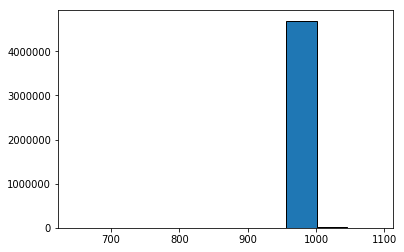

In [33]:
# Generate a histogram
plt.hist(medianbias.flatten(),range=(np.min(medianbias)-100,np.median(medianbias)+100),edgecolor='black')
plt.show()

### Display the median bias image


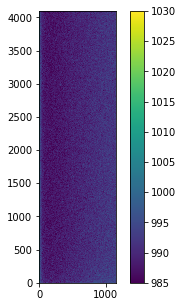

In [43]:
plt.figure(figsize=(5,5))
plt.imshow(medianbias,origin='lower',vmin=985,vmax=1030)
cb = plt.colorbar()
plt.show()

### Another approach that I would normally take to construct a median bias is to pre-allocate a multidimensional array of 0s of shape (4096  x 1155 x 5) and store the bias images along the 3rd (technically 2nd-dimension due to Python's 0-based indexing) (or z-axis in my mind)

In [19]:
# Generate the 2nd bias holder of shape (4096 x 1155 x 5)
biasholder2 = np.zeros((4096,1155,5))

# Store all the biases in the respective slots along the z-dimension.
biasholder2[:,:,0] = bias102
biasholder2[:,:,1] = bias103
biasholder2[:,:,2] = bias104
biasholder2[:,:,3] = bias105
biasholder2[:,:,4] = bias106

# Compute the median bias again, this time along the 2nd axis in np.median()
medianbias2 = np.median(biasholder2,2)

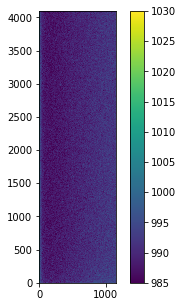

In [44]:
plt.figure(figsize=(5,5))
plt.imshow(medianbias2,origin='lower',vmin=985,vmax=1030)
cb = plt.colorbar()
plt.show()

# Masking

The concept of a bad pixel mask is to help distinguish "good" pixels from "bad pixels." For the purposes of our lab, a "bad pixel" refers to a pixel hit by a cosmic ray, or a dead/unreliable pixel on the CCD detector. Cosmic ray hits are random, so we would expect that it is unlikely (but not impossible) that cosmic rays would show up in different spatial locations on separate image frames. On the other hand, we would expect dead/unreliable pixels to be in the same exact pixel location on each frame.

A mask is an array that is the same shape as an image (in our case 4096 x 1155) that will identify pixels that are "good" or "bad". One common practice is set to "good pixels" = 0 and "bad pixels" = 1, though there are different practices (such as reversing the definitions of "good" and "bad" when it comes to 0 and 1).

For the example below, I will create a function that will take in a multidimensional array of images (N x 4096 x 1155) and output an (N x 4096 x 1155) array that holds the masks for the corresponding image. 

In psuedocode form, my algorithm will do the following:

1. Determine the amount of images from the input array.

2. Determine the dimensions of the image using the first image in the array.

3. Pre-allocate a blank array of zeros of shape (N x 4096 x 1155)

4. Initiate a loop for each image that will:
    i. Determine the median of the image
    
    ii. Determine the pixels within (median - 50) and (median + 50) using np.where()
    
    iii. Calculate the standard deviation of the pixels within the range determined from part ii.
    
    iv. Find the pixels within $\mathrm{median} \pm \alpha\times\sigma$ (We will choose $\alpha = \pi \sigma $ (yes $\pi$ = 3.14159..))
    
    v. Set all pixels defined in part iv. in the mask equal to 1.

In [65]:
def maskfunction(array,alpha):
    """ This function will take in an array (N x W x H) dimension of images and determine bad pixels. 
        We will use a sigma-clipping routine that will mask out pixels above or below alpha*sigma from 
        the median in each image in the stack
        
        array: An array of bias-subtracted images. The dimension of this array should be arranged such that
        the 0th dimension corresponds to which image we're on and the 1st and 2nd dimensions correspond to the
        spatial dimensions of each image.
        
        Written by Kyle K. M. Kabasares """
    
    # Identify how many images are in the stack
    N = array.shape[0]
    
    # Identify the spatial dimensions of an image
    ndy = array[0,:,:].shape[0]
    ndx = array[0,:,:].shape[1]
    
    # Create a holder mask array of zeros that will be returned as an output
    masks = np.zeros((N,ndy,ndx))
    
    # For loop that will create a mask for each image in the array
    for i in range(0,N):
        
        # Select the image we're working on
        img = array[i]
        
        # Calculate the median of the given image
        med = np.median(img)
        
        # Determine the subset of pixels that lie within -50 to +50 of the median value
        within50 = np.where((img >= med - 50) | (img <= med + 50))
        
        # Calculate the standard deviation of the image from the pixels within this range
        stdev = np.std(img)
        
        # Define "bad" pixels as pixels that are alpha*sigma above or below the median value
        badpix = np.where((img <= med - alpha*stdev) | (img >= med + alpha*stdev))
        
        # Change the corresponding indices in the mask to 1 if the pixel is bad and 0 if it is good
        masks[i][badpix] += 1    
    return masks

## I will first subtract the median bias from science frames b211011_0107.fits and b211011_0108.fits before storing them in an array usable with maskfunction.

In [66]:
# Bias subtract
sci107 = fits.open('b211011_0107.fits')[2].data - medianbias
sci108 = fits.open('b211011_0108.fits')[2].data - medianbias

In [67]:
# Store these in a 3D array
sciholder = np.array((sci107,sci108))
print('The shape of the science holder multidimensional array is',sciholder.shape)

The shape of the science holder multidimensional array is (2, 4096, 1155)


In [68]:
# Feed this into the masks function
maskholder = maskfunction(sciholder,np.pi)
print('The shape of the mask holder multidimensional array is',maskholder.shape)

The shape of the mask holder multidimensional array is (2, 4096, 1155)


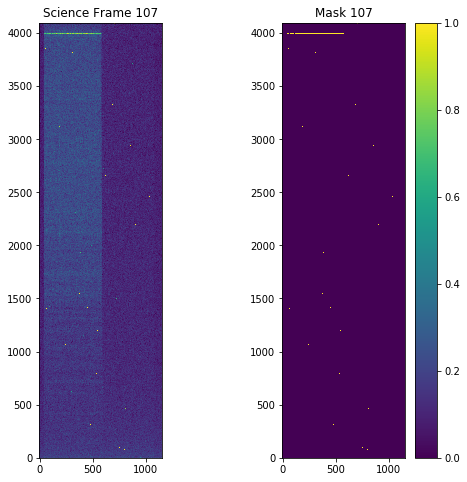

In [69]:
### Display the first image and its mask side by side
plt.figure(figsize=(8,8))
# First Image
plt.subplot(121)
plt.title('Science Frame 107')
plt.imshow(sci107,origin='lower',vmin=-5,vmax=100)

# Second Image
plt.subplot(122)
plt.title('Mask 107')
plt.imshow(maskholder[0,:,:],origin='lower') # Note that the first mask is in the 0th place
cb = plt.colorbar()
plt.show()

# Combining the Science Frames (the slow but straightforward for-loop approach)

We want to create a final science frame, C, that is derived from science images 107 and 108 and their masks. In essence the final image will be determined as follows:

i. **C[i,j] = Mean(Image107[i,j], Image108[i,j]) if both pixels are good (i.e. Mask107[i,j] = 0, and Mask108[i,j] = 0)  **

ii. **C[i,j] = Image107[i,j] if (i.e. Mask107[i,j] = 0, and Mask108[i,j] = 1) **

iii. **C[i,j] = Image108[i,j] if (i.e. Mask107[i,j] = 1, and Mask108[i,j] = 0) **

iv. **C[i,j] = (Some Placeholder Value) if (i.e. Mask107[i,j] = 1, and Mask108[i,j] = 1), meaning both pixels are bad **

#### In case iv, the placeholder value is up to you. This is sometimes referred to as "padding" which means to fill bad or unusable array entries with some value. Some choices are Placeholder = 0 or Placeholder = NaN (not a Number)

In [103]:
# We use a for-loop method to create the combined that will go through each array element
# The final image has the same dimensions as the two science frames

# Start with a blank zeros array for the combined image
C = np.zeros((4096,1155))

# Import each mask separately 
mask107 = maskholder[0,:,:]
mask108 = maskholder[1,:,:]

start_loop = time.time()

# Loop through each array element
for i in range(0,4096):
    for j in range(0,1155):
        
        # Both pixels good
        if (mask107[i,j] == 0 and mask108[i,j] == 0):
            C[i,j] = np.mean((sci107[i,j],sci108[i,j]))
        
        # Frame 107 good Frame 108 bad
        elif (mask107[i,j] == 0 and mask108[i,j] == 1):
            C[i,j] = sci107[i,j]
            
        # Frame 108 bad Frame 108 good
        elif (mask107[i,j] == 1 and mask108[i,j] == 0):
            C[i,j] = sci108[i,j]
            
        # If both pixels are bad, then pad with np.nan
        elif (mask107[i,j] == 1 and mask108[i,j] == 1):
            C[i,j] = np.nan
            
end_loop = time.time()
print('The for-loop approach took (in seconds)',end_loop-start_loop)

The for-loop approach took (in seconds) 59.51779508590698


# Display the combined image

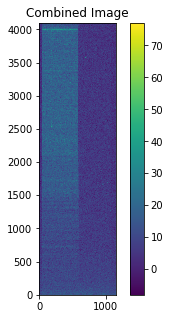

In [104]:
plt.figure(figsize=(5,5))
plt.imshow(C,origin='lower')
plt.title('Combined Image')
cb = plt.colorbar()
#plt.savefig('CombinedImage.png',dpi=300) # Uncomment this to save high-quality images into reports

# Combining the Sciences Frames (Much quicker method using a mask of 1s and NaNs)

In this next approach, I will demonstrate a **much quicker way** to combine an image by using masks of 1s and NaNs (not a number). The logic of this approach is as follows:

i. Set all "good pixels" = 1 and all "bad pixels" = np.nan in the mask.

ii. Multiply the science frame array (S) with the mask array (M).

iii. if M[i,j] = 1, then S[i,j] x M[i,j] = S[i,j] (the pixel is unchanged)

iv. if M[i,j] = np.nan, then S[i,j] x M[i,j] = np.nan (the bad pixels is now nan-valued).

v. Create the combined image, C, by having **C[i,j] = np.nanmean((S107[i,j] x M107[i,j]), (S108[i,j] x M108[i,j]))**

What step v. will do is that it will take the mean of all NON-NAN valued entries at the [i,j]th pixel location among all of the science frame. To illustrate what this means, consider the following case: 

**M107[i,j] = np.nan, M108[i,j] = 1**

**C[i,j] = np.nanmean((S107[i,j] x M107[i,j]), (S108[i,j] x M108[i,j])) = np.mean(S108[i,j]) = S108[i,j]** 

because the NaN entry in S107 is excluded, and the mean of a singular entity is itself.





### I will modify the maskfunction I wrote before to output masks of 1s and NaNs as opposed to 0s and 1s.

In [94]:
def maskfunctionNaN(array,alpha):
    """ This function will take in an array (N x W x H) dimension of images and determine bad pixels. 
        We will use a sigma-clipping routine that will mask out pixels above or below alpha*sigma from 
        the median in each image in the stack
        
        array: An array of bias-subtracted images. The dimension of this array should be arranged such that
        the 0th dimension corresponds to which image we're on and the 1st and 2nd dimensions correspond to the
        spatial dimensions of each image.
        
        Written by Kyle K. M. Kabasares """
    
    # Identify how many images are in the stack
    N = array.shape[0]
    
    # Identify the spatial dimensions of an image
    ndy = array[0,:,:].shape[0]
    ndx = array[0,:,:].shape[1]
    
    # Create a holder mask array of ones that will be returned as an output
    masks = np.ones((N,ndy,ndx))
    
    # For loop that will create a mask for each image in the array
    for i in range(0,N):
        
        # Select the image we're working on
        img = array[i]
        
        # Calculate the median of the given image
        med = np.median(img)
        
        # Determine the subset of pixels that lie within -50 to +50 of the median value
        within50 = np.where((img >= med - 50) | (img <= med + 50))
        
        # Calculate the standard deviation of the image from the pixels within this range
        stdev = np.std(img)
        
        # Define "bad" pixels as pixels that are alpha*sigma above or below the median value
        badpix = np.where((img <= med - alpha*stdev) | (img >= med + alpha*stdev))
        
        # Change the corresponding indices in the mask to 1 if the pixel is bad and 0 if it is good
        masks[i][badpix] = np.nan    
    return masks

### Generate the new masks of 1s and NaNs below

In [96]:
# Feed this into the masks function
nanmaskholder = maskfunctionNaN(sciholder,np.pi)
print('The shape of the mask holder multidimensional array is',maskholder.shape)

The shape of the mask holder multidimensional array is (2, 4096, 1155)


In [100]:
# Re-import the science images
sci107 = fits.open('b211011_0107.fits')[2].data - medianbias
sci108 = fits.open('b211011_0108.fits')[2].data - medianbias

In [111]:
# Extract the masks individually
nanmask107 = nanmaskholder[0,:,:]
nanmask108 = nanmaskholder[1,:,:]

# Create the combined image by multiplying the science image with its respective mask of 1s and NaNs and taking the median
# along the 0th axis

start =time.time()
sciholder2 = np.array((nanmask107*sci107,nanmask108*sci108)) # This has dimensions (2,4096,1155)

# Take np.nanmean() along the 0th axis to create the combined image
C2 = np.nanmean(sciholder2,0)
end = time.time()
print('The quicker combining method takes (in seconds)',end-start)

The quicker combining method takes (in seconds) 0.18153858184814453


C:\Users\Kyle Kabasares\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


# This method takes ~0.2 seconds compared to the for-loop's ~1 min. approach on my computer which is a factor of 300 increase in speed. 

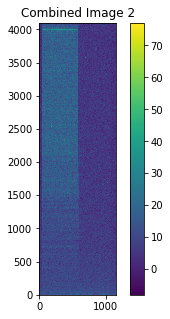

In [112]:
# Display the new Combined Image
plt.figure(figsize=(5,5))
plt.imshow(C2,origin='lower')
plt.title('Combined Image 2')
cb = plt.colorbar()
#plt.savefig('CombinedImage.png',dpi=300) # Uncomment this to save high-quality images into reports

# Appendix: Finding bad pixels that share the same pixel locations on multiple arrays.

As was stated before, cosmic ray hits are random and are expected to show up in different pixel locations on different science frames, whereas bad detector malfunctions or artifacts should be in the same place (generally speaking). What if we wanted to determine what fraction of our bad pixels were cosmic rays and what fraction were detector artifacts? If we assume $N_{bad} = N_{cosmic} + N_{detector} $, then $N_{bad} - N_{detector} = N_{cosmic}$

Examine the following lines of code:

In [122]:
# First set of pairs
x1 = np.array((1,20,35,45,64))
y1 = np.array((5,11,13,9,109))

# Second set of pairs
x2 = np.array((1,7,8,35,45,61,77))
y2 = np.array((5,2,1,13,9,10,89))

# Third set of pairs
x3 = np.array((1,6,7,35,45,64,77,1337,124))
y3 = np.array((5,5,1,13,9,100,89,13,168))

These are three sets of array of x and y pairs of varying lengths. What are the common pairs among all three sets? By visual inspection we can see (1,5), (35,13), and (45,9) are the pairs of (x,y) that always appear in each set. How might we code that up to have the computer tell us there are 3 pairs (or pixel locations if talking about a CCD array) that are shared? One approach might involve storing each (x,y) as its own unique element using the **numpy.intersect1d** function. See the example below:

In [126]:
# Define empty arrays
array1 = np.empty(len(x1), dtype=[('x',int), ('y',int)])
array2 = np.empty(len(x2), dtype=[('x',int), ('y',int)])
array3 = np.empty(len(x3), dtype=[('x',int), ('y',int)])

# Start storing the x_i, y_i pairs into the arrays
array1['x'] = x1
array1['y'] = y1

array2['x'] = x2
array2['y'] = y2

array3['x'] = x3
array3['y'] = y3

In [129]:
array1

array([( 1,   5), (20,  11), (35,  13), (45,   9), (64, 109)],
      dtype=[('x', '<i4'), ('y', '<i4')])

In [130]:
array2

array([( 1,  5), ( 7,  2), ( 8,  1), (35, 13), (45,  9), (61, 10),
       (77, 89)], dtype=[('x', '<i4'), ('y', '<i4')])

In [131]:
array3

array([(   1,   5), (   6,   5), (   7,   1), (  35,  13), (  45,   9),
       (  64, 100), (  77,  89), (1337,  13), ( 124, 168)],
      dtype=[('x', '<i4'), ('y', '<i4')])

### I will make use of the "reduce" function from the functools package in Python, read more here from the "Examples" section on the np.intersect1d page: https://numpy.org/doc/stable/reference/generated/numpy.intersect1d.html

In [133]:
from functools import reduce

In [139]:
# Find the common pixels amongst all the arrays
common_pixels = reduce(np.intersect1d,(array1,array2,array3))
print('The common x and y pairs are',common_pixels)
print('The amount of common pixels are',len(common_pixels))

The common x and y pairs are [( 1,  5) (35, 13) (45,  9)]
The amount of common pixels are 3


# Recall that np.where() used on a 2D array will determine the indices that satisfy the condition within the where command. For example, np.where(mask107 == 1) will tell us the indices of the pixels that are considered "bad".

In [157]:
print(np.where(mask107 == 1))

(array([   3,    4,    4, ..., 4088, 4090, 4091], dtype=int64), array([954, 954, 955, ..., 534, 708, 708], dtype=int64))


In [160]:
# These are the row indices 
y_107 = np.array(np.where(mask107==1))[0]
print(y_107)

[   3    4    4 ... 4088 4090 4091]


In [161]:
# These are the column indices
x_107 = print(np.array(np.where(mask107==1))[1])

[954 954 955 ... 534 708 708]


# Using the provided example above, and knowledge of how np.where() works, see if you can determine the commonly shared bad pixels among all the science frames.